In [118]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## Run optimization first

### Helper Functions

In [119]:
def clean_data(df):
    """
    Cleans the data by handling missing/odd values in the RET and PRC columns.
    
    For RET:
      - Replaces the special missing codes (-66.0, -77.0, -88.0, -99.0) with NaN.
    
    For PRC:
      - If the price is 0, it is set to NaN (indicating missing price).
      - If the price is negative, its absolute value is taken (since the negative sign
        is only a symbol to denote a bid/ask average).
    
    Parameters:
      df : pandas.DataFrame with columns including 'RET' and 'PRC'.
      
    Returns:
      A cleaned DataFrame with missing or anomalous values handled.
    """
    # --- Clean RET: Replace special codes with NaN ---
    missing_return_codes = [-66.0, -77.0, -88.0, -99.0]
    df["RET"] = df["RET"].replace(missing_return_codes, np.nan)
    
    # --- Clean PRC: Convert negative prices to positive; mark zero prices as NaN ---
    def clean_price(x):
        if x == 0:
            return np.nan
        else:
            return abs(x)
    
    df["PRC"] = df["PRC"].apply(clean_price)
    
    # Optionally, drop rows where either PRC or RET is missing.
    df_clean = df.dropna(subset=["PRC", "RET"]).copy()
    
    return df_clean

In [120]:
def single_stock_opt(df: DataFrame, 
                     window_length: int, 
                     start_index: int, 
                     forecast_horizon: int, 
                     smoothing_window: int, 
                     alpha_scale: float, 
                     beta: float, 
                     tau: float, 
                     w: float, 
                     penalty: float, 
                     Q_target: float, 
                     Q0: float, 
                     J0: float, 
                     gamma0: float, 
                     gammaT: float):
    '''
    Performs multi-period optimization for a single stock with given input parameters.
    
    Returns data over windowed period, the optimized impact states J_opt, 
    and optimized trade schedule Q_history
    
    '''
    
    df_window = df.iloc[start_index:start_index + window_length + 1].copy()
    T = window_length
    
    prices = df_window["PRC"].values  # length T+1
    dates = df_window["date"].values
    
    # synthetic alpha signal construction
    df_window["raw_alpha"] = (df_window["PRC"].shift(-forecast_horizon) / df_window["PRC"] - 1)
    df_window["alpha"] = df_window["raw_alpha"].rolling(smoothing_window, min_periods=1).mean()
    df_window["alpha"].fillna(method="ffill", inplace=True)
    
    df_window["alpha"] *= alpha_scale
    
    t = np.arange(len(df_window))
    df_window["alpha"] *= np.exp(-beta * t)
    
    alpha = df_window["alpha"].values[:T+1]  # alpha_0,...,alpha_T
    delta_alpha = np.diff(alpha)
    
    # setting remaining parameters 
    gamma = np.linspace(gamma0, gammaT, T+1)
    lambda_vals = np.exp(gamma)
    delta_gamma = np.diff(gamma)
    
    # decision variable: J \in R^(T+1), where J[0] = J0 is fixed.
    J = cp.Variable(T+1)

    objective_terms = []
    
    # sum from k=0 to T-1
    for k in range(T):
        term_k = (np.exp(-gamma[k]) *
                  ( J[k] * delta_alpha[k] 
                    + (1/tau + delta_gamma[k]) * alpha[k] * J[k]
                    - (1/tau) * (w * cp.square(J[k])) 
                    - delta_gamma[k] * (0.5 * w * cp.square(J[k]) )
                  )
                 )
        objective_terms.append(term_k)
        
    # terminal term at k=T:
    terminal_term = np.exp(-gamma[T]) * (alpha[T] * J[T] - 0.5 * w * cp.square(J[T]))
    objective_terms.append(terminal_term)
    
    # deviation term:
    position_increment = []
    for i in range(T):
        position_increment.append((J[i+1] - (1 - 1/tau)*J[i]) / lambda_vals[i])
    Q_T_expr = Q0 + cp.sum(cp.hstack(position_increment))
    deviation = Q_target - Q_T_expr
    penalty_term = - penalty * cp.square(deviation)
    
    # full objective:
    objective = cp.Maximize(cp.sum(cp.hstack(objective_terms)) + penalty_term)

    constraints = [J[0] == J0]

    # formulate problem
    prob = cp.Problem(objective, constraints)
    
    
    # solve problem 
    try:
        prob.solve(solver=cp.SCS, verbose=True)
    except Exception as e:
        print("Solver failed:", e)
        
    print("Optimal value:", prob.value)
    J_opt = J.value  # optimal J_t sequence
    
    
    # recover portfolio position Q_t
    Q_history = [Q0]
    for i in range(T):
        delta_Q_i = (J_opt[i+1] - (1 - 1/tau)*J_opt[i]) / lambda_vals[i]
        Q_history.append(Q_history[-1] + delta_Q_i)
    Q_history = np.array(Q_history)
    
    
    return df_window, J_opt, Q_history

In [121]:
def plot(df_window: DataFrame, 
         J_opt: DataFrame, 
         Q_history: DataFrame, 
         Q_target: float, 
         window_length: int):
    
    '''
    Plots the result of single stock optimization. 
    Plots both impact state J_t and portfolio positions Q_t over time.
    
    '''
    
    dates = df_window["date"].values

    plt.figure(figsize=(12,6))
    plt.plot(dates, J_opt, marker='o')
    plt.xlabel("Date")
    plt.ylabel("Optimal Impact State J_t")
    plt.title("Optimal Impact State over Time")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12,6))
    plt.plot(dates, Q_history, marker='o', label="Optimized Portfolio")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Position Q_t")
    plt.title("Portfolio Trajectory: Optimized vs. Benchmark")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # final metrics
    final_Q = Q_history[-1]
    print(f"Final portfolio position: {final_Q:.2f} (Target: {Q_target})")
    print(f"Deviation from target: {abs(final_Q - Q_target):.2f}")

### Run Optimization

In [122]:
df_og = pd.read_csv("crsp_nflx.csv", parse_dates=["date"])
df_og.sort_values("date", inplace=True)
df_og.reset_index(drop=True, inplace=True)
df_og = df_og.dropna(subset=["PRC"])

df = clean_data(df_og)

In [61]:
window_length = 50
start_index = 0
T = window_length

forecast_horizon = 5
smoothing_window = 5
alpha_scale = 0.5
beta = 0.1

tau = 5.0
w = 0.1
penalty = 0.5
Q_target = 100.0
Q0 = 0.0
J0 = 0

gamma0 = 0.0
gammaT = 0.1
gamma = np.linspace(gamma0, gammaT, T+1)

In [62]:
window, J_opt, Q_history = single_stock_opt(df, 
                window_length, start_index, 
                forecast_horizon, smoothing_window, alpha_scale, beta, 
                tau, w, penalty, Q_target, Q0, J0, 
                gamma0, gammaT)

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Mar 30 10:43:40 AM: Your problem has 51 variables, 1 constraints, and 0 parameters.
(CVXPY) Mar 30 10:43:40 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 30 10:43:40 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 30 10:43:40 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 30 10:43:40 AM: Compiling problem (target solver=SCS).
(CVXPY) Mar 30 10:43:40 AM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> ConeM

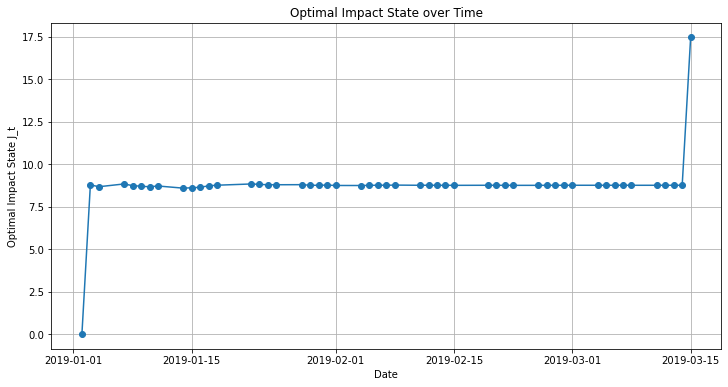

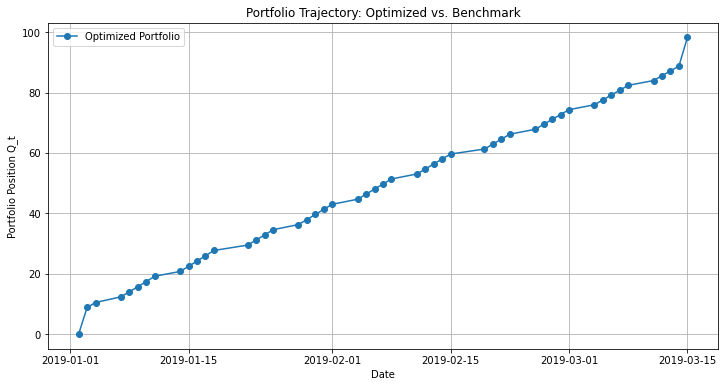

Final portfolio position: 98.26 (Target: 100.0)
Deviation from target: 1.74


In [63]:
plot(window, J_opt, Q_history, Q_target, window_length)

### Recover Trade Schedule

In [64]:
prices = window["PRC"].values  # length T+1
dates = window["date"].values

In [65]:
initial_cash = Q_target * prices[0]
trades_opt = np.diff(Q_history)

## Metrics for Optimized Trajectory

### Helper Functions

In [66]:
def compute_wealth_with_impact(trade_schedule, prices, initial_cash, tau, gamma, w):
    """
    Simulate a wealth trajectory given a trade schedule and market prices,
    accounting for price impact.

    Parameters:
      trade_schedule: array of trades (delta Q) for t=0,...,T-1.
      prices: array of market prices for t=0,...,T+1.
      initial_cash: initial cash.
      tau: impact decay parameter.
      gamma: gamma schedule (array of length T+1).
      w: impact coefficient (e.g., effective price = price + w * J).
      
    Returns:
      wealth: array of wealth over time (length T+1)
      Q_traj: array of positions over time (length T+1)
      J_sim: simulated impact state sequence (length T+1)
    """
    T = len(trade_schedule)
    J_sim = simulate_J(trade_schedule, tau, gamma)
    
    cash = initial_cash
    Q = 0.0
    wealth = [initial_cash]
    Q_traj = [Q]
    
    for t in range(T):
        # Use the simulated impact at time t+1 to adjust execution price.
        P_eff = prices[t] + w * J_sim[t+1]
        cash -= trade_schedule[t] * P_eff
        Q += trade_schedule[t]
        # Mark-to-market using next period's price:
        wealth.append(cash + Q * prices[t+1])
        Q_traj.append(Q)
    return np.array(wealth), np.array(Q_traj), J_sim

In [69]:
# -------------------------------
# Comprehensive Metrics Including Impact
# -------------------------------
def compute_all_metrics_opt(wealth, Q_traj, trades, J_sim, prices, initial_cash, Q_target, w, trading_days=252):
    """
    Computes a set of performance metrics that incorporate the effect of price impact.
    This function extends standard metrics (wealth, cumulative return, volatility, etc.)
    with impact-related metrics such as total impact cost, average impact cost per share,
    average effective vs. market price, and impact premium.

    Parameters:
      wealth       : wealth trajectory (length T+1).
      Q_traj       : portfolio positions (length T+1).
      trades       : trade schedule (delta Q, length T).
      J_sim        : simulated impact state (length T+1).
      prices       : market prices (length T+1).
      initial_cash : initial cash value.
      Q_target     : target final position.
      w            : impact coefficient.
      trading_days : number of trading days per year (default 252).
      
      
    Returns:
      A dictionary with a comprehensive set of metrics.
    """
    final_wealth = wealth[-1]
    cum_return = (final_wealth - initial_cash) / initial_cash * 100
    final_position = Q_traj[-1]
    deviation = abs(final_position - Q_target)
    
    daily_returns = np.diff(wealth) / wealth[:-1]
    ann_vol = np.std(daily_returns) * np.sqrt(trading_days) * 100
    sharpe = (np.mean(daily_returns) / np.std(daily_returns)) * np.sqrt(trading_days) if np.std(daily_returns) > 0 else np.nan
    
    running_max = np.maximum.accumulate(wealth)
    drawdowns = (wealth - running_max) / running_max
    max_dd = np.min(drawdowns) * 100
    
    avg_position = np.mean(np.abs(Q_traj) + 1e-6)
    turnover = np.sum(np.abs(trades)) / avg_position if avg_position != 0 else np.nan
    
    impl_short = (wealth[-1] - initial_cash) / initial_cash * 100
    
    total_impact_cost = np.sum(trades * (w * J_sim[1:]))
    total_traded_shares = np.sum(np.abs(trades))
    avg_impact_cost_per_share = total_impact_cost / total_traded_shares if total_traded_shares != 0 else np.nan
    
    effective_prices = prices[:-1] + w * J_sim[1:]
    if total_traded_shares != 0:
        avg_effective_price = np.sum(np.abs(trades) * effective_prices) / total_traded_shares
        avg_market_price = np.sum(np.abs(trades) * prices[:-1]) / total_traded_shares
    else:
        avg_effective_price = np.nan
        avg_market_price = np.nan
    impact_premium = ((avg_effective_price - avg_market_price) / avg_market_price * 100) if avg_market_price and avg_market_price != 0 else np.nan
    
    avg_J = np.mean(np.abs(J_sim))
    max_J = np.max(np.abs(J_sim))
    
    metrics = {
        "Final Wealth": final_wealth,
        "Cumulative Return (%)": cum_return,
        "Final Position": final_position,
        "Deviation from Target": deviation,
        "Annualized Volatility (%)": ann_vol,
        "Sharpe Ratio": sharpe,
        "Max Drawdown (%)": max_dd,
        "Turnover": turnover,
        "Implementation Shortfall (%)": impl_short,
        "Total Impact Cost": total_impact_cost,
        "Average Impact Cost per Share": avg_impact_cost_per_share,
        "Average Effective Price": avg_effective_price,
        "Average Market Price": avg_market_price,
        "Impact Premium (%)": impact_premium,
        "Average |J|": avg_J,
        "Max |J|": max_J
    }
    return metrics

### Compute

In [117]:
wealth_opt_imp, Q_traj_opt_imp, J_sim_opt = compute_wealth_with_impact(trades_opt, prices, initial_cash, tau, gamma, w)

# Compute comprehensive metrics for the optimized schedule:
metrics_opt = compute_all_metrics_opt(wealth_opt_imp, Q_traj_opt_imp, trades_opt, J_sim_opt, prices, initial_cash, Q_target, w, trading_days=252)

## All metrics for Benchmark Trade Schedules

### Helper Functions

In [71]:
def simulate_J(trade_schedule, tau, gamma):
    """
    Given a benchmark trade schedule (array of delta Q, length T),
    the constant tau, and a gamma schedule (length T+1), simulate the impact sequence J.
    
    Returns an array J of length T+1.
    """
    T = len(trade_schedule)
    J = np.zeros(T+1)
    
    for t in range(T):
        J[t+1] = (1 - 1/tau) * J[t] + np.exp(gamma[t]) * trade_schedule[t]
    return J

In [72]:
def generate_benchmark_trades(T, Q_target):
    """
    Generate three benchmark trade schedules for T periods:
      - All-at-Once: Execute entire Q_target at t=0.
      - Linear Trade: Trade evenly over T periods.
      - Half-at-Midpoint: Execute half at t=T//2 and half at t=T-1.
    Returns dictionaries mapping strategy name to trade schedule (array of length T).
    """
    trades = {}
    # All-at-Once: trade full Q_target at t=0, then 0.
    trade_all = np.zeros(T)
    trade_all[0] = Q_target
    trades["All-at-Once"] = trade_all
    
    # Linear: equal trade each period.
    trade_linear = np.full(T, Q_target / T)
    trades["Linear Trade"] = trade_linear
    
    # Half-at-Midpoint: half at midpoint and half at final period.
    trade_half = np.zeros(T)
    mid = T // 2
    trade_half[mid] = Q_target / 2
    trade_half[-1] = Q_target / 2
    trades["Half-at-Midpoint"] = trade_half
    
    return trades

In [96]:
def compute_all_metrics_benchmark(wealth, Q_traj, trades, J_sim, prices, initial_cash, Q_target, w, trading_days=252):
    """
    Computes a comprehensive set of performance metrics that incorporate price impact.
    
    Parameters:
      wealth       : array of wealth trajectory (length T+1).
      Q_traj       : array of portfolio positions over time (length T+1).
      trades       : array of trades (delta Q, length T).
      J_sim        : simulated impact sequence (length T+1), from benchmark simulation.
      prices       : array of market prices (length T+1).
      initial_cash : initial cash value.
      Q_target     : target final portfolio position.
      w            : impact coefficient (used to adjust the execution price).
      trading_days : number of trading days in a year (default 252).
      
      
    Returns:
      A dictionary with many performance metrics including:
         - Final Wealth and Cumulative Return (%)
         - Final Position and Deviation from Target
         - Annualized Volatility (%) and Sharpe Ratio
         - Maximum Drawdown (%)
         - Turnover (Total traded volume / average position)
         - Implementation Shortfall (%)
         - Total Impact Cost
         - Average Impact Cost per Share
         - Average Effective Price and Average Market Price
         - Impact Premium (%)
         - Average |J| and Maximum |J|
    """
    # Final wealth and cumulative return:
    final_wealth = wealth[-1]
    cum_return = (final_wealth - initial_cash) / initial_cash * 100
    
    # Final position and deviation:
    final_position = Q_traj[-1]
    deviation = abs(final_position - Q_target)
    
    # Daily returns for volatility and Sharpe ratio:
    daily_returns = np.diff(wealth) / wealth[:-1]
    ann_vol = np.std(daily_returns) * np.sqrt(trading_days) * 100
    sharpe = (np.mean(daily_returns) / np.std(daily_returns)) * np.sqrt(trading_days) if np.std(daily_returns) > 0 else np.nan
    
    # Maximum drawdown:
    running_max = np.maximum.accumulate(wealth)
    drawdowns = (wealth - running_max) / running_max
    max_dd = np.min(drawdowns) * 100
    
    # Turnover: sum(|trade|) / average(|position|)
    avg_position = np.mean(np.abs(Q_traj) + 1e-6)
    turnover = np.sum(np.abs(trades)) / avg_position if avg_position != 0 else np.nan
    
    # Implementation Shortfall:
    impl_short = (wealth[-1] - initial_cash) / initial_cash * 100  # Typically, IS is benchmark - strategy; here we use strategy absolute
    
    # Impact-related metrics:
    # Total Impact Cost: sum_{t} (trade[t] * (w * J_sim[t+1]))
    total_impact_cost = np.sum(trades * (w * J_sim[1:]))
    
    total_traded_shares = np.sum(np.abs(trades))
    avg_impact_cost_per_share = total_impact_cost / total_traded_shares if total_traded_shares != 0 else np.nan
    
    # Effective execution prices at each trade time:
    effective_prices = prices[:-1] + w * J_sim[1:]
    # Weighted averages (by absolute trade size):
    if total_traded_shares != 0:
        avg_effective_price = np.sum(np.abs(trades) * effective_prices) / total_traded_shares
        avg_market_price = np.sum(np.abs(trades) * prices[:-1]) / total_traded_shares
    else:
        avg_effective_price = np.nan
        avg_market_price = np.nan
    
    impact_premium = ((avg_effective_price - avg_market_price) / avg_market_price * 100) if avg_market_price and avg_market_price != 0 else np.nan
    
    # Statistics on the simulated impact state J:
    avg_J = np.mean(np.abs(J_sim))
    max_J = np.max(np.abs(J_sim))
    
    metrics = {
        "Final Wealth": final_wealth,
        "Cumulative Return (%)": cum_return,
        "Final Position": final_position,
        "Deviation from Target": deviation,
        "Annualized Volatility (%)": ann_vol,
        "Sharpe Ratio": sharpe,
        "Max Drawdown (%)": max_dd,
        "Turnover": turnover,
        "Implementation Shortfall (%)": impl_short,
        "Total Impact Cost": total_impact_cost,
        "Average Impact Cost per Share": avg_impact_cost_per_share,
        "Average Effective Price": avg_effective_price,
        "Average Market Price": avg_market_price,
        "Impact Premium (%)": impact_premium,
        "Average |J|": avg_J,
        "Max |J|": max_J
    }
    return metrics


### Compute

In [97]:
window_length = 50
start_index = 0
T = window_length

forecast_horizon = 5
smoothing_window = 5
alpha_scale = 0.5
beta = 0.1

tau = 5.0
w = 0.1
penalty = 0.5
Q_target = 100.0
Q0 = 0.0
J0 = 0

gamma0 = 0.0
gammaT = 0.1
gamma = np.linspace(gamma0, gammaT, T+1)

initial_cash = Q_target * prices[0]

In [98]:
trades_benchmark = generate_benchmark_trades(T, Q_target)

# Compute wealth trajectories for each benchmark, now incorporating price impact.
wealth_benchmarks = {}
Q_benchmarks = {}
J_benchmarks = {}

In [113]:
for name, trade_schedule in trades_benchmark.items():
    wealth, Q_traj, J_sim = compute_wealth_with_impact(trade_schedule, prices, initial_cash, tau, gamma, w)
    wealth_benchmarks[name] = wealth
    Q_benchmarks[name] = Q_traj
    J_benchmarks[name] = J_sim

In [114]:
metrics_all_at_once = compute_all_metrics_benchmark(wealth_benchmarks["All-at-Once"], 
                                                    Q_benchmarks["All-at-Once"], 
                                                    trades_benchmark["All-at-Once"], 
                                                    J_benchmarks["All-at-Once"], 
                                                    prices, initial_cash, Q_target, w, trading_days = 252)

# print("All-at-Once Metrics (with Impact):")
# for key, value in metrics_all_at_once.items():
#     print(f"{key}: {value:.4f}")

In [115]:
metrics_half = compute_all_metrics_benchmark(wealth_benchmarks["Half-at-Midpoint"], 
                                                    Q_benchmarks["Half-at-Midpoint"], 
                                                    trades_benchmark["Half-at-Midpoint"], 
                                                    J_benchmarks["Half-at-Midpoint"], 
                                                    prices, initial_cash, Q_target, w, trading_days = 252)

# print("Half-at-Midpoint Metrics (with Impact):")
# for key, value in metrics_half.items():
#     print(f"{key}: {value:.4f}")

In [116]:
metrics_linear = compute_all_metrics_benchmark(wealth_benchmarks["Linear Trade"], 
                                                    Q_benchmarks["Linear Trade"], 
                                                    trades_benchmark["Linear Trade"], 
                                                    J_benchmarks["Linear Trade"], 
                                                    prices, initial_cash, Q_target, w, trading_days = 252)

# print("Linear Trade Metrics (with Impact):")
# for key, value in metrics_linear.items():
#     print(f"{key}: {value:.4f}")

# All Metrics Together

In [110]:
metrics_all = {
    "Optimized": metrics_opt,
    "Linear": metrics_linear,
    "All-at-Once": metrics_all_at_once,
    "Half-at-Midpoint": metrics_half

}

df_metrics = pd.DataFrame(metrics_all)
df_metrics.index.name = "Metric"
df_metrics

,Optimized,Linear,All-at-Once,Half-at-Midpoint
Metric,,,,
Final Wealth,28909.151780,28499.126767,35145.999000,27195.699408
Cumulative Return (%),8.006993,6.475106,31.308373,1.605393
Final Position,98.256864,100.000000,100.000000,100.000000
Deviation from Target,1.743136,0.000000,0.000000,0.000000
Annualized Volatility (%),17.749343,18.215564,41.936864,11.029474
Sharpe Ratio,2.277287,1.827745,3.486915,0.782717
Max Drawdown (%),-4.066643,-4.472116,-9.473659,-2.792900
Turnover,1.991336,2.000000,1.020000,3.923077
Implementation Shortfall (%),8.006993,6.475106,31.308373,1.605393


### Plot of Trajectories

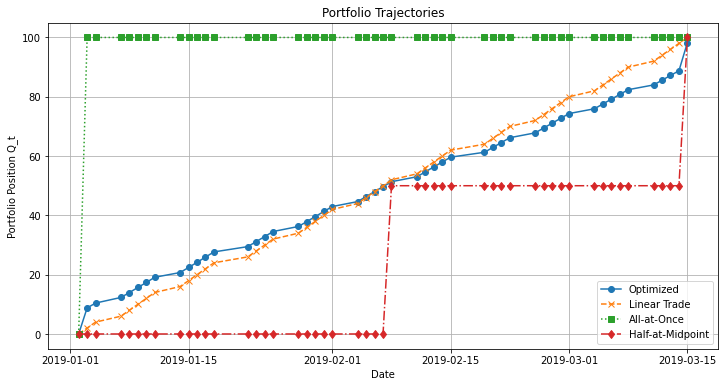

In [127]:
# dates = df["date"].values[:T+1]
dates = window["date"].values

plt.figure(figsize=(12,6))
plt.plot(dates, Q_history, marker= "o", label="Optimized")
plt.plot(dates, Q_benchmarks["Linear Trade"], marker="x", linestyle="--", label="Linear Trade")
plt.plot(dates, Q_benchmarks["All-at-Once"], marker="s", linestyle=":",label="All-at-Once")
plt.plot(dates, Q_benchmarks["Half-at-Midpoint"], marker="d", linestyle="-.",label="Half-at-Midpoint")
plt.xlabel("Date")
plt.ylabel("Portfolio Position Q_t")
plt.title("Portfolio Trajectories")
plt.legend()
plt.grid(True)
plt.show()